To help make it easier for you to participate in our motion forecasting challenge, we provide an example notebook for the task

## A simple baseline

Let's say we have our (very very naive) prediction function;

In [ ]:
def prediction(trajectory,num_points=30,avg_points=1):
    #a simple prediction function that predict straight line with constant velocity
    velocity_x_mps = []
    velocity_y_mps = []
    for i in range(1,avg_points+1,1):
        velocity_x_mps.append(trajectory[-i,0] - trajectory[-(1+i),0])
        velocity_y_mps.append(trajectory[-i,1] - trajectory[-(1+i),1])
        
    velocity_x_mps = np.mean(velocity_x_mps)
    velocity_y_mps = np.mean(velocity_y_mps)
    
    current_traj = trajectory[-1]
    results = np.zeros((len(trajectory)+num_points,2))
    
    results[0:len(trajectory)] = trajectory
    
    for i in range(num_points):
        results[len(trajectory)+i] = np.array([current_traj[0]+velocity_x_mps,current_traj[1]+velocity_y_mps])
        current_traj = results[len(trajectory)+i]
    return results

In [ ]:
import torch
from torch import nn
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from typing import Any, Dict, List, Tuple, Union
import time
import copy
import torch.nn.functional as F
import pickle
import pandas as pd
from argoverse.map_representation.map_api import ArgoverseMap
import os
import pickle as pkl
from shapely.geometry import Point, Polygon, LineString, LinearRing
import math

Let's try that on our argoverse forecasting test set

In [ ]:
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader

##set root_dir to the correct path to your dataset folder
train_root_dir = '/home/jingche/Desktop/argo/forecasting_train_v1.1/train/data/'

afl = ArgoverseForecastingLoader(train_root_dir)

print('Total number of sequences:',len(afl))

Total number of sequences: 205942


In [ ]:
f = open('/home/jingche/Desktop/argo/feature/forecasting_features_train.pkl','rb')  
info = pickle.load(f)  
# pd.set_option('display.width',None)
# pd.set_option('display.max_rows',None)
# pd.set_option('display.max_colwidth',None)
# print(info)
# inf=str(info)
# ft = open('/home/jingche/Desktop/argo/feature/test1.csv', 'w')
# ft.write(inf)

In [ ]:
class MyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MyLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = num_layers)
        self.fc1 = nn.Linear(hidden_dim, 20)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
#         print("out shape is : " + str(np.shape(out)))
        out = out[ -1:, :, :]
#         print("after out shape is : " + str(np.shape(out)))
        out = self.fc1(out)
        out = out.view(10,1,2)
        return out, hidden

In [ ]:
e = afl[50].agent_traj

In [ ]:
temp = torch.from_numpy(afl[50].agent_traj[:40].reshape(40, 1, 2))

In [ ]:
temp.shape
t = np.array([2,1])
np.amax(e, axis = 0)
afl.counter
afl.agent_traj
avm = ArgoverseMap()

/home/jingche/Desktop/argo/argoverse-api/argoverse/map_representation/map_api.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lane_polygons = np.array(self.get_vector_map_lane_polygons(city_name))
/home/jingche/Desktop/argo/argoverse-api/argoverse/map_representation/map_api.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  driveable_areas = np.array(self.get_vector_map_driveable_areas(city_name))


In [ ]:
a, b = (np.array([2,3]) - np.array([1,1]))/np.array([2,2])

In [ ]:
np.array([[2,3], [4, 6]]) * np.array([[2,3], [1, 2]])

array([[ 4,  9],
       [ 4, 12]])

In [ ]:
def rotate(x, y, theta):
    x_rotate = np.cos(theta)*x + np.sin(theta)*y
    y_rotate = np.sin(theta)*x - np.cos(theta)*y
    return x_rotate, y_rotate

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self,
                 input_size: int = 2,
                 embedding_size: int = 8,
                 hidden_size: int = 16):
        """Initialize the encoder network.

        Args:
            input_size: number of features in the input
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM

        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
                                 
    def forward(self, x: torch.FloatTensor, hidden: Any) -> Any:

        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        return hidden

class DecoderRNN(nn.Module):
    """Decoder Network."""
    def __init__(self, embedding_size=8, hidden_size=16, output_size=2):
        """Initialize the decoder network.

        Args:
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
            output_size: number of features in the output

        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(output_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        """Run forward propagation.

        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            output: output from lstm
            hidden: final hidden state

        """
        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        output = self.linear2(hidden[0])
        return output, hidden

In [ ]:
def get_relative_distance(data : np.ndarray, mode : str, pred_len : int, obs_len : int):
    '''
    convert absolute distance to relative distance in place
    the relative value is the origin
    
    '''
    if mode == "test":
        traj_len = obs_len
    else:
        traj_len = pred_len + obs_len
    
    for i in range(traj_len - 1, 0, -1):
        data[ i, :2] = data[ i, :2] - data[ i - 1, :2]
    data[ 0, :2] = 0

In [ ]:
class train_loader(object):
    def __init__(self, batch_size, obs_len, pred_len):
        self.batch_size = batch_size
        self.pred_len = pred_len
        self.obs_len = obs_len
        print('batch_size:', self.batch_size)
        print('pred_len:', self.pred_len)
        print('obs_lens:', self.obs_len)

    def normalize_centuralize(self, x):
        new_list = []
        x_origin, y_origin = x[0]
        end_x, end_y = x[39]
        theta = np.arctan2(x[39, 1] - y_origin, x[39, 0] - x_origin)
        for i in range(len(x)):
            x_temp, y_temp = rotate(x[i, 0]- x_origin, x[i, 1] - y_origin,theta)
            new_list.append(np.array([x_temp, y_temp]))
        return np.array(new_list), x_origin, y_origin, theta
    
    def input_list_to_batch(self, x):
        temp_x = np.array(x);
#         for i in range(len(x)):
#         print("len train  " + str(len_train))
#         print("input_dim  " + str(input_dim))
#         temp = torch.from_numpy(temp_x.reshape((int(len_train), 1, self.input_dim))).float()
#         print("type" + str(type(temp[0,0,1])))
#         new_list.append(temp.float())
        return temp_x

    def output_list_to_batch(self, x,  x_origin, y_origin, theta):
        temp_x = np.array(x);
        for i in range(len(x)):
            x_temp, y_temp = rotate(temp_x[i, 0], temp_x[i, 1], theta)
            temp_x[i, 0] = x_temp
            temp_x[i, 1] = y_temp
#         temp = torch.from_numpy(temp_x.reshape((int(len_out), 1, self.input_dim))).float()
        return temp_x
    
    def load_and_process_data(self, afl, length):
        train_input = []
        train_target = []
        count = 0
        li = []
        lo = []
        
        for i in range(length):
            x_n, x_origin, y_origin, theta = self.normalize_centuralize(afl[i].agent_traj)
            get_relative_distance(x_n, "train", self.pred_len, self.obs_len)
            net_input = x_n[:40]
            net_target = x_n[40:]
            if i % self.batch_size == 0 and i != 0:
                train_input.append(torch.from_numpy(np.array(copy.deepcopy(li))).float())
                train_target.append(torch.from_numpy(np.array(copy.deepcopy(lo))).float())
                li = []
                lo = []
            li.append(copy.deepcopy(net_input))
            lo.append(copy.deepcopy(net_target))

        return train_input, train_target

In [ ]:
class ModelUtils:
    """Utils for LSTM baselines."""
    def save_checkpoint(self, save_dir: str, state: Dict[str, Any]) -> None:
        """Save checkpoint file.
        
        Args:
            save_dir: Directory where model is to be saved
            state: State of the model

        """
        filename = "{}/LSTM_rollout{}.pth.tar".format(save_dir,
                                                      state["rollout_len"])
        torch.save(state, filename)

    def load_checkpoint(
            self,
            checkpoint_file: str,
            encoder: Any,
            decoder: Any,
            encoder_optimizer: Any,
            decoder_optimizer: Any,
    ) -> Tuple[int, int, float]:
        """Load the checkpoint.

        Args:
            checkpoint_file: Path to checkpoint file
            encoder: Encoder model
            decoder: Decoder model 

        Returns:
            epoch: epoch when the model was saved.
            rollout_len: horizon used
            best_loss: loss when the checkpoint was saved

        """
        if os.path.isfile(checkpoint_file):
            print("=> loading checkpoint '{}'".format(checkpoint_file))
            checkpoint = torch.load(checkpoint_file)
            epoch = checkpoint["epoch"]
            best_loss = checkpoint["best_loss"]
            rollout_len = checkpoint["rollout_len"]
            if use_cuda:
                encoder.module.load_state_dict(
                    checkpoint["encoder_state_dict"])
                decoder.module.load_state_dict(
                    checkpoint["decoder_state_dict"])
            else:
                encoder.load_state_dict(checkpoint["encoder_state_dict"])
                decoder.load_state_dict(checkpoint["decoder_state_dict"])
            encoder_optimizer.load_state_dict(checkpoint["encoder_optimizer"])
            decoder_optimizer.load_state_dict(checkpoint["decoder_optimizer"])
            print(
                f"=> loaded checkpoint {checkpoint_file} (epoch: {epoch}, loss: {best_loss})"
            )
        else:
            print(f"=> no checkpoint found at {checkpoint_file}")

        return epoch, rollout_len, best_loss

    def my_collate_fn(self, batch: List[Any]) -> List[Any]:
        """Collate function for PyTorch DataLoader.

        Args:
            batch: Batch data

        Returns: 
            input, output and helpers in the format expected by DataLoader

        """
        _input, output, helpers = [], [], []

        for item in batch:
            _input.append(item[0])
            output.append(item[1])
            helpers.append(item[2])
        _input = torch.stack(_input)
        output = torch.stack(output)
        return [_input, output, helpers]

    def init_hidden(self, batch_size: int,
                    hidden_size: int) -> Tuple[Any, Any]:
        """Get initial hidden state for LSTM.

        Args:
            batch_size: Batch size
            hidden_size: Hidden size of LSTM

        Returns:
            Initial hidden states

        """
        return (
            torch.zeros(batch_size, hidden_size).float(),
            torch.zeros(batch_size, hidden_size).float(),
        )

In [ ]:
def normalize_centuralized(x):
    new_list = []
    x_origin, y_origin = x[0]
    theta = np.arctan2(x[39, 1] - y_origin, x[39, 0] - x_origin)
    for i in range(len(x)):
        x_temp, y_temp = rotate(x[i, 0] - x_origin, x[i, 1] - y_origin, theta)
        new_list.append([x_temp, y_temp])
    return np.array(new_list), x_origin, y_origin, theta

In [ ]:
np.shape(afl.agent_traj)

(50, 2)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
afl = afl[0]
x_n, x_origin, y_origin, theta = normalize_centuralized(afl.agent_traj)

In [ ]:
xtemp = np.array(x_n)

Here is an example of our prediction, initial trajectory in blue and the predicted trajectory in red

In [ ]:
# print(afl)

In [ ]:
xtemp[0,0]

0.0

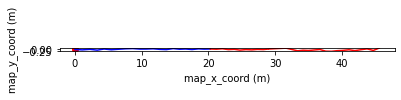

In [ ]:
ax = plt.gca()
plt.plot(xtemp[0,0],xtemp[0,1],'-o',c='r') #starting point here
plt.plot(xtemp[:21,0],xtemp[:21,1],'-',c='b')
plt.plot(xtemp[20:,0],xtemp[20:,1],'-',c='r')

plt.xlabel('map_x_coord (m)')
plt.ylabel('map_y_coord (m)')
ax.set_aspect('equal')
plt.show()

Due to the multimodal nature of the problem, our challenge allows for (expects) multiple forecasts for each object.

For the purposes of this tutorial we will use different averaging windows to create multiple entries per object.

In [ ]:
# def get_multiple_forecasts(afl):
#     predict_traj = []
#     for i in range(9,3,-1):
#         predict_traj.append(prediction(afl.agent_traj,avg_points=(i)))
#     return np.array(predict_traj)

In [ ]:
# predict_traj = get_multiple_forecasts(afl)

In [ ]:
# ax = plt.gca()

# plt.plot(predict_traj[0,0,0],predict_traj[0,0,1],'-o',c='r') #starting point here
# plt.plot(predict_traj[0,:21,0],predict_traj[0,:21,1],'-',c='b')
# predict_input = []
# for i in range(1):
#     predict_input.append(afl.agent_traj)
#     # plt.plot(predict_traj[i,20:,0],predict_traj[i,20:,1],'-',c=np.random.rand(3,))
# plt.xlabel('map_x_coord (m)')
# plt.ylabel('map_y_coord (m)')
# ax.set_aspect('equal')
# plt.show()

In [ ]:
print(afl.current_seq.name)
print(afl[50])

138076.csv
Seq : /home/jingche/Desktop/argo/forecasting_train_v1.1/train/data/187064.csv
        ----------------------
        || City: MIA
        || # Tracks: 153
        ----------------------


## Train Config

In [ ]:
ROLLOUT_LENS = 10
OBS_LENS = 40
ENCODER_SAVE_PATH = "/home/jingche/Desktop/argo/model_save/encoder"
DECODER_SAVE_PATH = "/home/jingche/Desktop/argo/model_save/decoder"
TRAIN_SIZE = 64000*3
BATCH_SIZE = 64
EPOCH = 10
criterion = nn.MSELoss()
encoder = EncoderRNN(input_size = 2)
decoder = DecoderRNN(output_size = 2)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr= 0.01)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr= 0.01)
start_rollout_idx = 0
model_utils = ModelUtils()

## Test Config

In [ ]:
START_TEST_IDX = 64000*3 + 1
TEST_SIZE = 10000
ROLLOUT_LENS = 10
FORECASTED_SAVE_DIR = "/home/jingche/Desktop/argo/model_save/forecasted_result/"
TEST_PROCESSED_DATA_DIR = "/home/jingche/Desktop/argo/model_save/test_processed_data/"

## Start Loading Training DataSet

In [ ]:
# Setting Dataloaders
len(afl)
input_dim = 2;
hidden_dim = 64;
num_layers = 1;
output_dim = 2;
train_data = train_loader(BATCH_SIZE, OBS_LENS, ROLLOUT_LENS)
train_input, train_target = train_data.load_and_process_data(afl, TRAIN_SIZE)
print("load finished")

batch_size: 64
pred_len: 10
obs_lens: 40


KeyboardInterrupt: 

In [ ]:
epoch = 0
global_start_time = time.time()
best_loss = float("inf")
prev_loss = best_loss
while epoch < EPOCH:
    start = time.time()
    train(
        train_input,
        train_target,
        epoch,
        criterion,
        encoder,
        decoder,
        encoder_optimizer,
        decoder_optimizer,
        model_utils,
        10,
    )
    end = time.time()
    epoch = epoch + 1
    print(
       f"Training epoch completed"
    )
print(
   f" --- Training session completed ---"
)
train_data = []
train_input = []
train_target = []

In [ ]:
ENCODER_SAVE_PATH = "/home/jingche/Desktop/argo/model_save/encoder/encoder"
DECODER_SAVE_PATH = "/home/jingche/Desktop/argo/model_save/decoder/decoder"
torch.save(encoder.state_dict(), ENCODER_SAVE_PATH)
torch.save(decoder.state_dict(), DECODER_SAVE_PATH)

# Load Test Data

In [ ]:
ENCODER_SAVE_PATH = "/home/jingche/Desktop/argo/model_save/encoder/encoder"
DECODER_SAVE_PATH = "/home/jingche/Desktop/argo/model_save/decoder/decoder"
model_utils = ModelUtils()
encoder = EncoderRNN(input_size = 2)
decoder = DecoderRNN(output_size = 2)
encoder.load_state_dict(torch.load(ENCODER_SAVE_PATH))
decoder.load_state_dict(torch.load(DECODER_SAVE_PATH))
encoder.eval()
decoder.eval()

DecoderRNN(
  (linear1): Linear(in_features=2, out_features=8, bias=True)
  (lstm1): LSTMCell(8, 16)
  (linear2): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
class test_loader(object):
    def __init__(self, obs_len , pred_len, afl, start_idx, test_data_size, batch_size, test_data_save_dir):
        self.afl = afl
        self.pred_len = pred_len
        self.obs_len = obs_len
        self.batch_size = batch_size
        self.start_idx = start_idx
        self.test_data_size = test_data_size
        self.test_data_container = {'DATA': [], 'ORIGIN': [], 'ROTATION': [], 'GROUND_TRUTH' : [] }
        self.test_data_save_dir = test_data_save_dir
        
    def normalize_centuralize(self, x):
        new_list = []
        x_origin, y_origin = x[0]
        end_x, end_y = x[self.obs_len - 1]
        theta = np.arctan2(x[self.obs_len - 1, 1] - y_origin, x[self.obs_len - 1, 0] - x_origin)
        for i in range(len(x)):
            if (i < self.obs_len):
                x_temp, y_temp = rotate(x[i, 0]- x_origin, x[i, 1] - y_origin, theta)
                new_list.append(np.array([x_temp, y_temp]))
            else:
                new_list.append(np.array([x[i, 0], x[i, 1]]))
        return np.array(new_list), x_origin, y_origin, theta
    
    def load_and_process_test_data(self):
        test_input_data = []
        test_input_origin = []
        test_input_rotation = []
        test_abs_traj = []
        
        count = 0
        traj_i = []
        traj_o = []
        traj_abs = []
        origin = []
        angle = []
        
        
        for i in range(self.test_data_size):
            index = self.start_idx + i
            x_n, x_origin, y_origin, theta = self.normalize_centuralize(afl[index].agent_traj)
            get_relative_distance(x_n, "test", self.pred_len, self.obs_len)
            net_input = x_n[:self.obs_len]
            net_target = x_n[self.obs_len:]
                
            traj_i.append(copy.deepcopy(net_input))
            traj_o.append(copy.deepcopy(net_target))
            traj_abs.append(copy.deepcopy(afl[index].agent_traj))
            origin.append(np.array((x_origin, y_origin)))
            angle.append(theta)
            
            
            if (i + 1) % self.batch_size == 0 and i != 0:
                test_input_data.append(torch.from_numpy(np.array(copy.deepcopy(traj_i))).float())
                test_abs_traj.append(np.array(copy.deepcopy(traj_abs)))
                test_input_origin.append(np.array(copy.deepcopy(origin)))
                test_input_rotation.append(np.array(copy.deepcopy(angle)))            
                traj_i = []
                traj_o = []
                origin = []
                angle = []
                traj_abs = []
      
        self.test_data_container['DATA'] = copy.deepcopy(test_input_data)
        self.test_data_container['ORIGIN'] = copy.deepcopy(test_input_origin)
        self.test_data_container['ROTATION'] = copy.deepcopy(test_input_rotation)
        self.test_data_container['GROUND_TRUTH'] = copy.deepcopy(test_abs_traj)
        
        with open(os.path.join(self.test_data_save_dir, f"{self.start_idx}_test_processed_data.pkl"),"wb") as f:
            pkl.dump(self.test_data_container, f)

In [ ]:
def get_abs_traj(input_: np.ndarray, output : np.ndarray):
    '''
    convert relative distance to absolute distance in place
    the relative value is the origin
    
    '''
    
    batch_size = input_.shape[0]
    obs_len = input_.shape[1]
    pred_len = output.shape[1]
    input_[:, 0, :] = 0
    for i in range(1, obs_len):
        input_[:, i, :] = input_[:, i, :] + input_[:, i - 1, :]
    
    output[:, 0, :] =  output[:, 0, :] + input_[:, -1, :]
    for i in range(1, pred_len):
        output[:, i, :] = output[:, i, :] + output[:, i - 1, :]

In [ ]:
def resume_to_absolute_coordinate(decoder_outputs, test_origin, test_rotation, rollout_len):
    # transfer to absolute coordinate shape: batch_size, seq_length, out_size
    # return size same to decoder_output
    batch_size, seq_length, ouput_size = decoder_outputs.shape
    result = np.zeros(decoder_outputs.shape)
    for idx in range(batch_size):
#         element = decoder_outputs[idx, :, :]
#         origin_x, origin_y = test_origin[idx]
        angle = test_rotation[idx]
        temp_x, temp_y = rotate(decoder_outputs[ idx, :, 0], decoder_outputs[ idx, :, 1],  angle)
        temp = np.vstack((temp_x, temp_y)).T
#         print(temp.shape)
        temp =  temp + test_origin[idx]
        result[idx, :, :] = temp
    return result

In [ ]:
def test( 
        test_loader: Any, #{"DATA" : list, "ORIGIN" : list, "ROTATION" : list},
        encoder: Any,
        decoder: Any,
        model_utils: Any,
        start_idx: int,
        forecasted_save_dir,
        rollout_len: int = 10,):
    
    forecasted_trajectories = []
    test_input_data = test_loader.test_data_container["DATA"]
    test_input_origin = test_loader.test_data_container["ORIGIN"]
    test_input_rotation = test_loader.test_data_container["ROTATION"]
    
    for i in range(len(test_input_data)):
        test_input = test_input_data[i]
        test_origin = test_input_origin[i]
        test_rotation = test_input_rotation[i]
        
        #net work set to eval mode
        decoder.eval()
        encoder.eval()

        #Encoder
        batch_size = test_input.shape[0]
        input_length = test_input.shape[1]
        input_shape = test_input.shape[2]

        #initialize hidden state
        encoder_hidden = model_utils.init_hidden(batch_size, encoder.hidden_size)

        #iterate over every element in batch
        for ei in range(input_length):
            encoder_input = test_input[:, ei, :]
            encoder_hidden = encoder(encoder_input, encoder_hidden)

        #initialize decoder
        decoder_input = encoder_input[:,:2]

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden

        # Initialize decoder output size
        decoder_outputs = torch.zeros(batch_size, rollout_len, input_shape)

        for di in range(rollout_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            decoder_outputs[:, di, :] = decoder_output

            # use own prediciotn to predict
            decoder_input = decoder_output

        # transfer to absolute coordinate shape: batch_size, seq_length, out_size
        output_r = decoder_outputs.detach().clone().cpu().numpy()
        input_ = test_input.detach().clone().cpu().numpy()
        get_abs_traj(input_, output_r)
        decoder_outputs_absolute = resume_to_absolute_coordinate(output_r, test_origin, test_rotation, rollout_len)
            
        forecasted_trajectories.append(decoder_outputs_absolute)
    
    with open(os.path.join(forecasted_save_dir, f"{start_idx}_test_result.pkl"),"wb") as f:
        pkl.dump(forecasted_trajectories, f)
    
    return forecasted_trajectories

## Load Test Data

In [ ]:
test_data_loader = test_loader(OBS_LENS, ROLLOUT_LENS, afl, START_TEST_IDX, TEST_SIZE, BATCH_SIZE, TEST_PROCESSED_DATA_DIR) #obs_len , pred_len, afl, start_idx, test_data_size, batch_size)
test_data_loader.load_and_process_test_data()

In [ ]:
test_data_dic = test_data_loader.test_data_container

In [ ]:
result = test(test_data_loader, encoder, decoder, model_utils, START_TEST_IDX, FORECASTED_SAVE_DIR, ROLLOUT_LENS)

In [ ]:
result[0][1]

array([[ 154.19903778, 2514.07720939],
       [ 154.13877033, 2515.47234336],
       [ 154.08461021, 2516.84191504],
       [ 154.03897189, 2518.22035972],
       [ 153.99181627, 2519.58503715],
       [ 153.94627546, 2520.93468467],
       [ 153.90204405, 2522.26972953],
       [ 153.85832571, 2523.59078971],
       [ 153.81469988, 2524.89927665],
       [ 153.77102446, 2526.19667045]])

In [ ]:
ls = LineString(result[0][1])

In [ ]:
np.array(ls)

array([[ 154.19903778, 2514.07720939],
       [ 154.13877033, 2515.47234336],
       [ 154.08461021, 2516.84191504],
       [ 154.03897189, 2518.22035972],
       [ 153.99181627, 2519.58503715],
       [ 153.94627546, 2520.93468467],
       [ 153.90204405, 2522.26972953],
       [ 153.85832571, 2523.59078971],
       [ 153.81469988, 2524.89927665],
       [ 153.77102446, 2526.19667045]])

## Visualize the result

In [ ]:
TEST_INDEX = 14
test_data_dic["GROUND_TRUTH"][0].shape
origin_x_t, origin_y_t = test_data_dic["ORIGIN"][0][TEST_INDEX]
x_absolute = test_data_dic["GROUND_TRUTH"][0][TEST_INDEX, : , 0]
y_absolute = test_data_dic["GROUND_TRUTH"][0][TEST_INDEX, : , 1]
x_forecasted = result[0][TEST_INDEX, : ,0]
y_forecasted = result[0][TEST_INDEX, : ,1]
y_absolute.shape
y_forecasted.shape

(10,)

To participate in our competition, you need to upload the result file to our evaluation server on EvalAI https://evalai.cloudcv.org/. Make sure that your results are in the right format, and then call our helper function `generate_forecasting_h5`

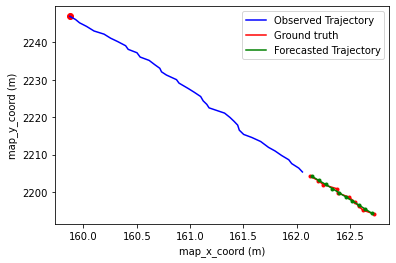

In [ ]:
plt.plot(origin_x_t,origin_y_t,'-o',c='r') #starting point here
plt.plot(x_absolute[:40],y_absolute[:40],'-',c='b', label = "Observed Trajectory") #input sequence
plt.plot(x_absolute[40:],y_absolute[40:],'-',c='r', label = "Ground truth") #ground truth
plt.plot(x_absolute[40:],y_absolute[40:],'.',c='r') #ground truth
plt.plot(x_forecasted[:],y_forecasted[:],'-',c='g', label = "Forecasted Trajectory") #forecasted 
plt.plot(x_forecasted[:],y_forecasted[:],'.',c='g') #forecasted 
plt.xlabel('map_x_coord (m)')
plt.ylabel('map_y_coord (m)')
ax.set_aspect('equal')
plt.legend()
plt.show()

In [ ]:
# from argoverse.evaluation.competition_util import generate_forecasting_h5

# output_path = 'competition_files/'

# generate_forecasting_h5(output_all, output_path) #this might take awhile

You are all set!! 

Simply upload the output file `competition_files/argoverse_forecasting_baseline.h5` to our evaluation server on https://evalai.cloudcv.org/ and see how well you did it

## Evaluation Metrics FDE & ADE

In [ ]:
def get_ade(forecasted_trajectory: np.ndarray, gt_trajectory: np.ndarray) -> float:
    """Compute Average Displacement Error.

    Args:
        forecasted_trajectory: Predicted trajectory with shape (pred_len x 2)
        gt_trajectory: Ground truth trajectory with shape (pred_len x 2)

    Returns:
        ade: Average Displacement Error

    """
    pred_len = forecasted_trajectory.shape[1]
    ade = np.zeros(64)
    for i in range(pred_len):
        ade = ade + np.sqrt((forecasted_trajectory[:, i, 0] - gt_trajectory[:, i, 0])**2 + (forecasted_trajectory[:, i, 1] - gt_trajectory[:, i, 1])**2)
    print(ade/pred_len)
    return ade/pred_len

In [ ]:
def get_fde(forecasted_trajectory: np.ndarray, gt_trajectory: np.ndarray) -> float:
    """Compute Final Displacement Error.

    Args:
        forecasted_trajectory: Predicted trajectory with shape (pred_len x 2)
        gt_trajectory: Ground truth trajectory with shape (pred_len x 2)

    Returns:
        fde: Final Displacement Error

    """
#     print(gt_trajectory.shape)
    fde = np.sqrt(
        (forecasted_trajectory[:, -1, 0] - gt_trajectory[:, -1, 0]) ** 2
        + (forecasted_trajectory[:, -1, 1] - gt_trajectory[:, -1, 1]) ** 2
    )
    return fde

In [ ]:
test_forecast_result = open(os.path.join(FORECASTED_SAVE_DIR, f"{START_TEST_IDX}_test_result.pkl"),'rb') #二进制格式读文件
test_result = pkl.load(test_forecast_result) 

test_ground_truth = open(os.path.join(TEST_PROCESSED_DATA_DIR, f"{START_TEST_IDX}_test_processed_data.pkl"),'rb') #二进制格式读文件
test_gt = pkl.load(test_ground_truth)

In [ ]:
len(test_result)
a = np.array(((2,3), (2,3)))
b = np.array(((4,4), (4,4)))
sum(np.sqrt(a**2 + b**2))

array([ 8.94427191, 10.        ])

In [ ]:
test_gt["GROUND_TRUTH"][0].shape

(64, 50, 2)

In [ ]:
def conpute_evaluation_metrics(forecasted_traj_list, ground_truth_traj_list, batch_size, obs_len):
    fde = 0
    ade = 0
    data_len = len(forecasted_traj_list)
    for idx in range(data_len):
        # shape : 64, 10, 2
        forecasted_traj_batch = forecasted_traj_list[idx]
        ground_truth_traj_batch = ground_truth_traj_list[idx][:, obs_len:, :]
#         print("the size of ground_truth_traj_batch is: " + str(ground_truth_traj_batch.shape))
        fde_temp = get_fde(forecasted_traj_batch, ground_truth_traj_batch)
        ade_temp = get_ade(forecasted_traj_batch, ground_truth_traj_batch)
        fde = sum(fde_temp)/batch_size + fde
        ade = sum(ade_temp)/batch_size + ade

    return fde/data_len, ade/data_len

In [ ]:
test_groundtruth = test_gt["GROUND_TRUTH"]
fde, ade = conpute_evaluation_metrics(test_result, test_groundtruth, BATCH_SIZE, OBS_LENS)

[0.55879247 0.66720481 0.21941707 0.21733573 0.16668179 0.30584908
 1.60505936 0.66101209 1.06924339 0.18229817 0.11500534 0.42738061
 0.27389277 1.02957701 0.12085395 1.28569845 0.28403841 3.84377866
 1.52775335 0.92795346 0.28645667 0.4499527  1.79879156 0.13067992
 0.87018126 0.22360426 0.39030316 1.46508538 0.4497882  0.22360043
 0.65306283 0.3413086  1.52436674 0.40741758 0.81728989 1.52983648
 0.1989452  0.50670974 0.18191253 0.1493666  0.55741143 0.43807206
 0.41813222 0.78556358 0.10409888 1.01079427 0.98910309 1.04512444
 2.04323818 0.88958481 1.5355145  0.26232092 0.33049682 2.21945147
 1.15697542 0.34915007 0.22145642 0.72046677 1.04103515 0.33351212
 4.32876025 0.71933433 1.35667059 0.17636186]
[1.7932051  0.47570302 0.35498771 0.19948406 0.20970597 0.42296957
 0.27120573 1.18048468 0.92000881 0.25262459 0.30945763 3.66532746
 0.72885972 0.58943931 0.33722127 0.34948545 4.07258074 0.66415208
 0.74495595 0.19676604 0.31662918 0.31310583 0.1179342  2.01044875
 0.43281649 0.28

In [ ]:
print("------------------------------------------------")
print(f"Prediction Horizon : {ROLLOUT_LENS}, Obs_Lens : {OBS_LENS}")
print("------------------------------------------------")
print(f"ADE : {ade}, FDE : {fde}")
print("------------------------------------------------")

------------------------------------------------
Prediction Horizon : 10, Obs_Lens : 40
------------------------------------------------
ADE : 0.6806243463664613, FDE : 1.1753032302495436
------------------------------------------------


## Result 

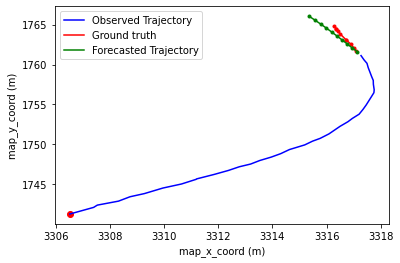

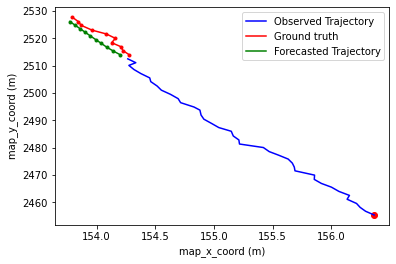

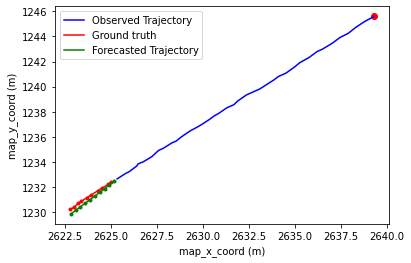

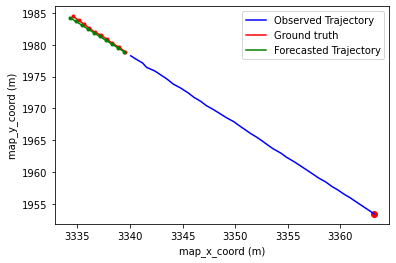

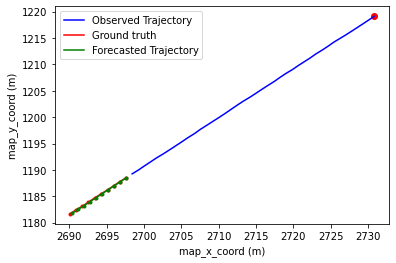

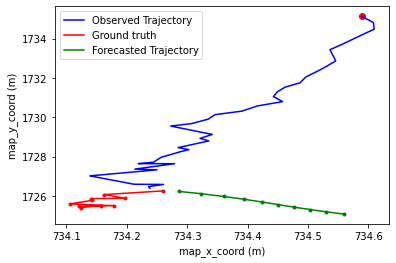

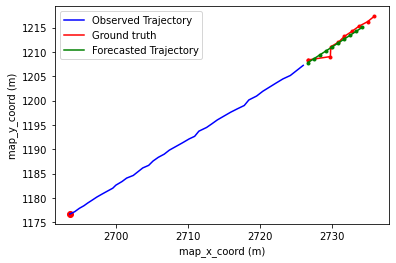

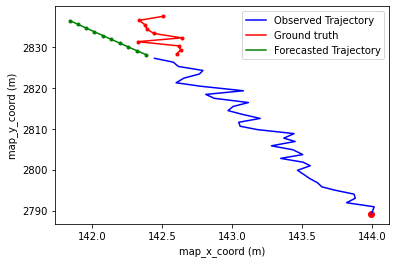

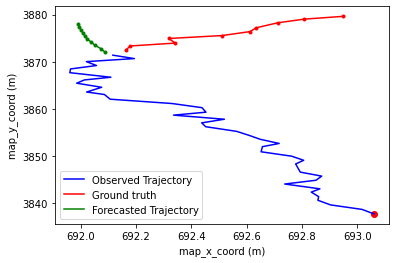

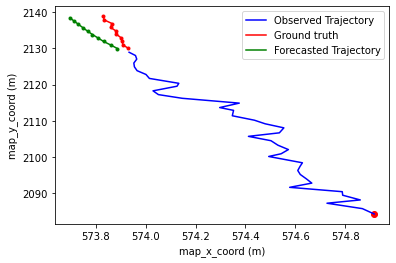

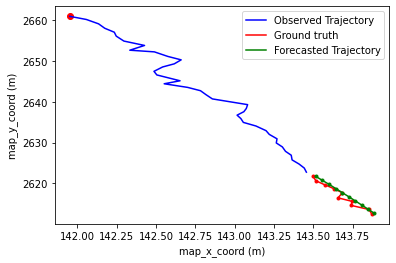

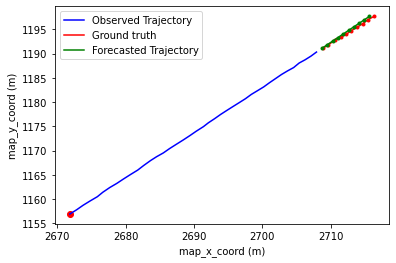

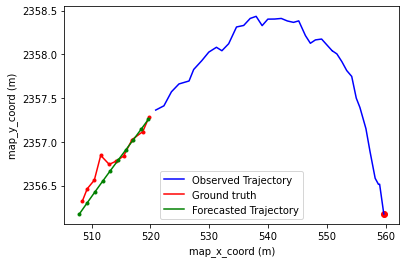

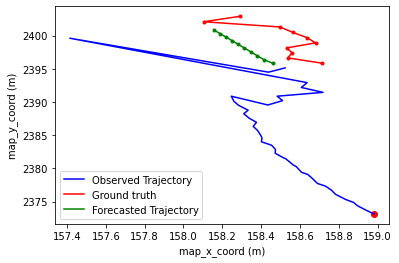

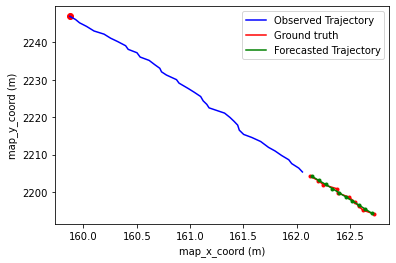

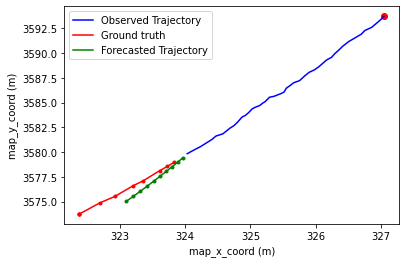

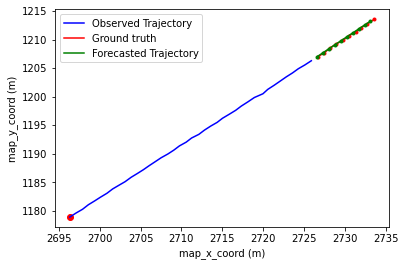

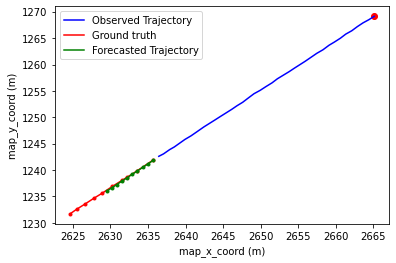

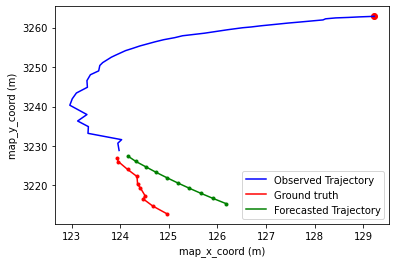

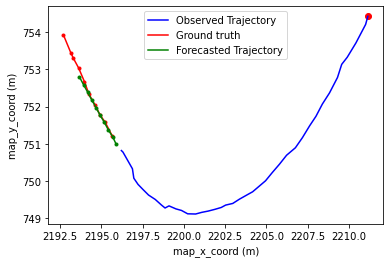

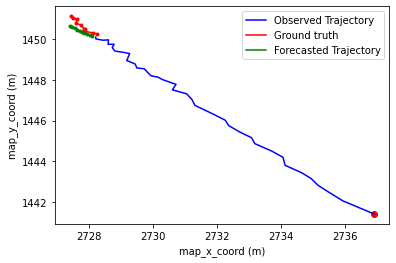

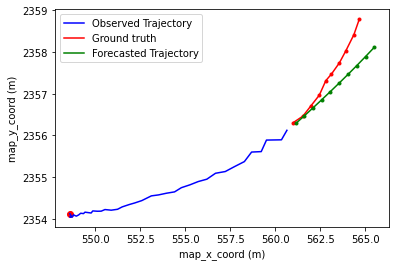

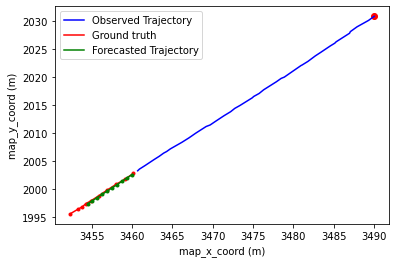

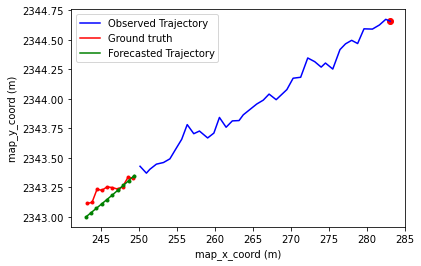

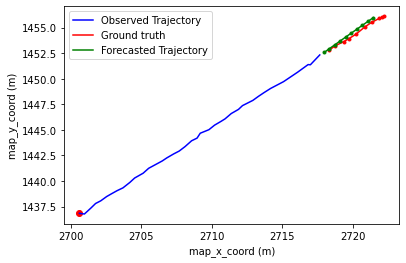

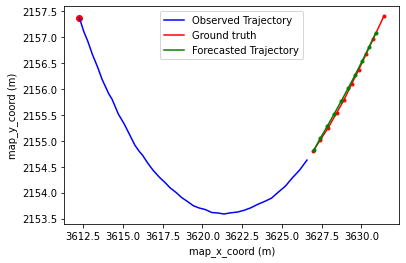

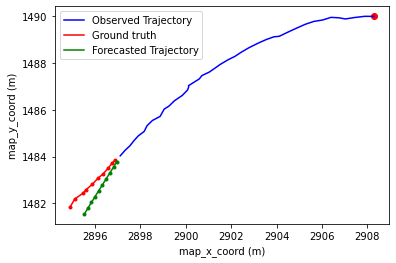

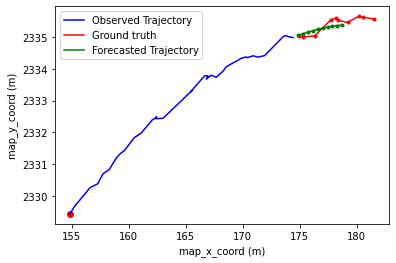

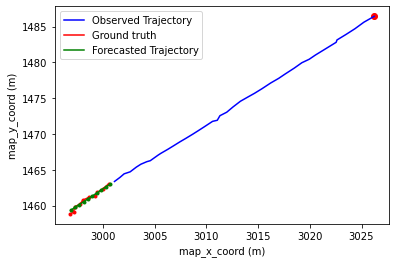

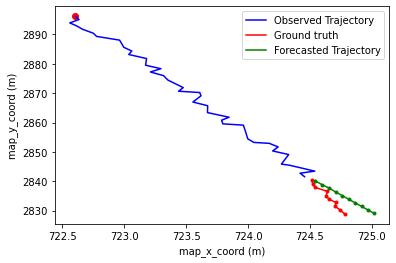

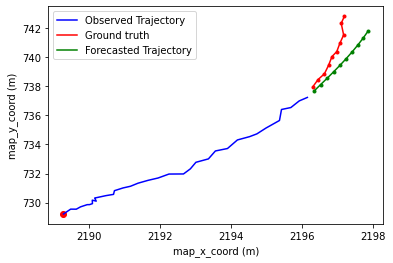

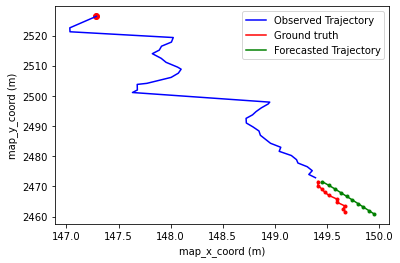

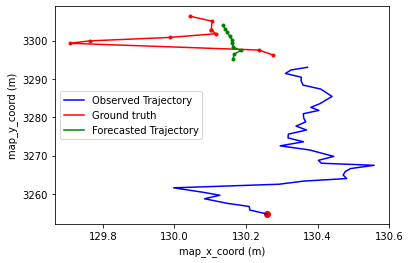

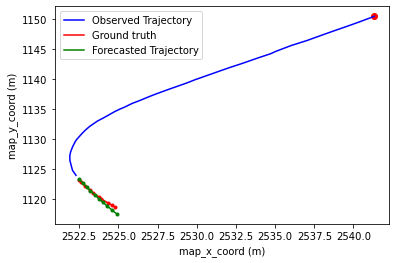

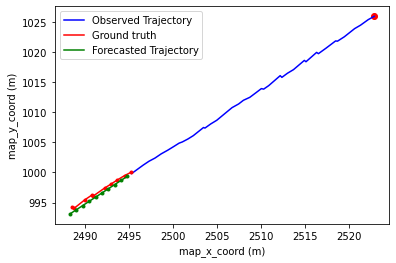

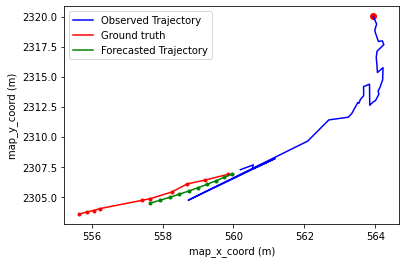

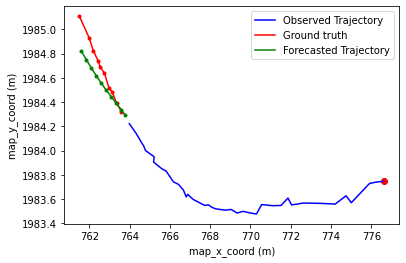

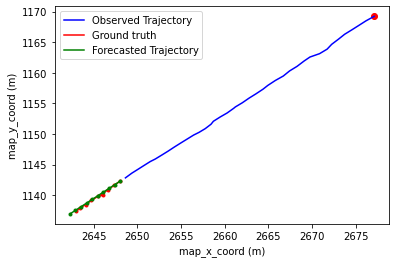

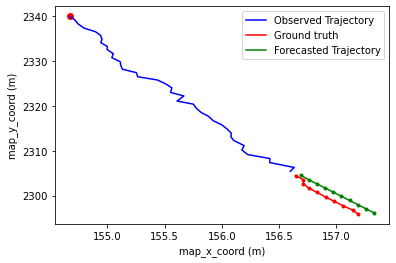

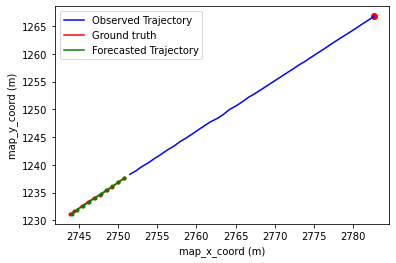

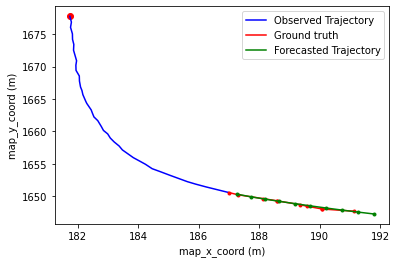

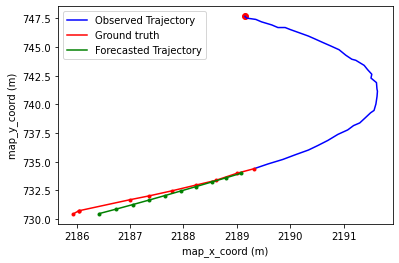

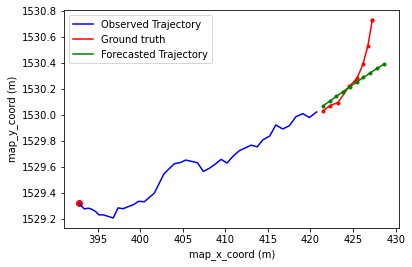

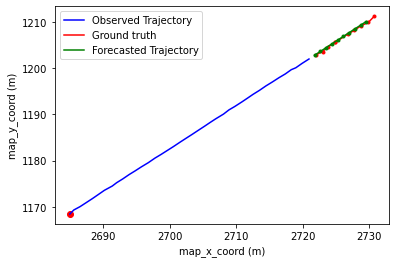

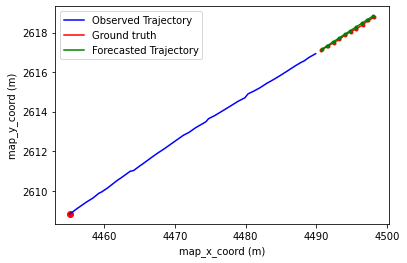

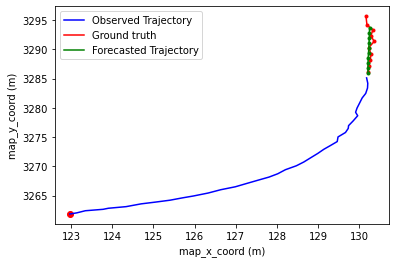

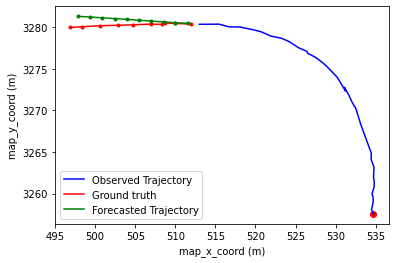

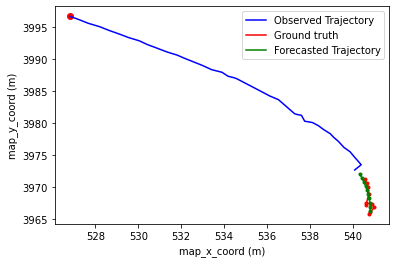

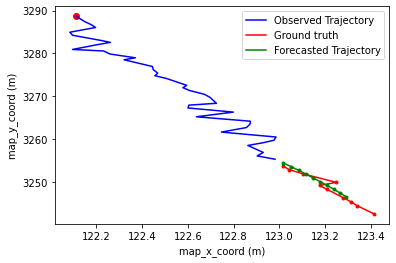

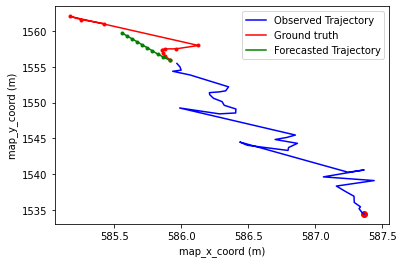

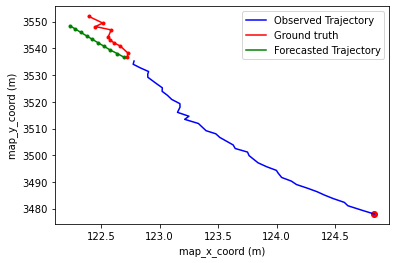

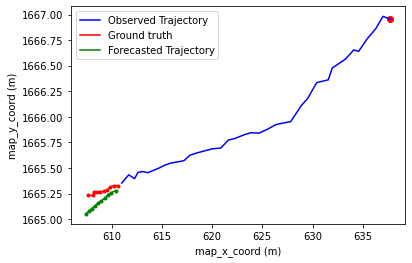

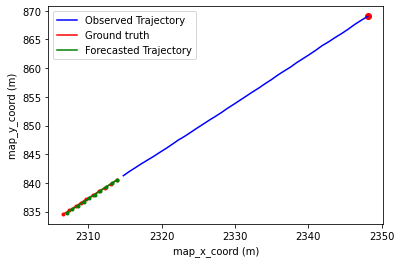

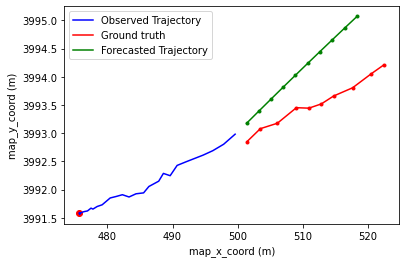

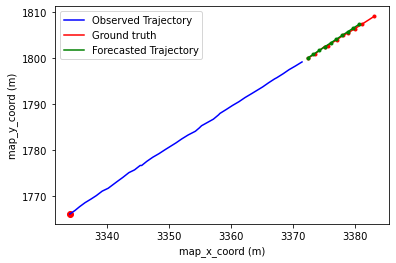

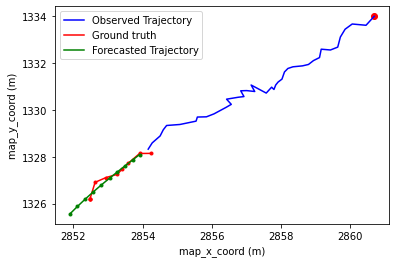

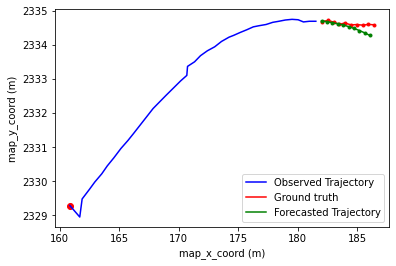

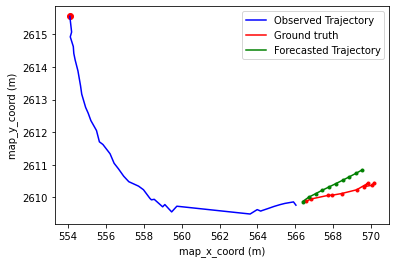

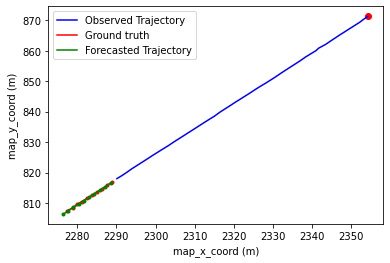

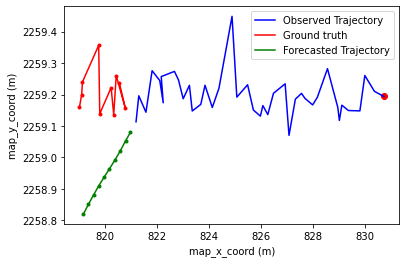

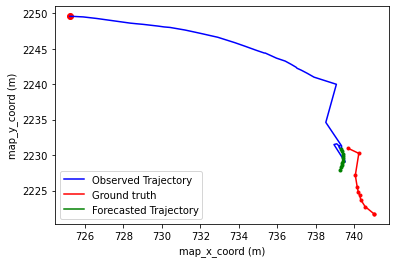

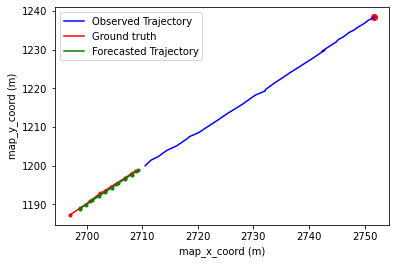

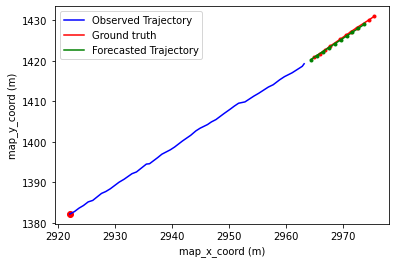

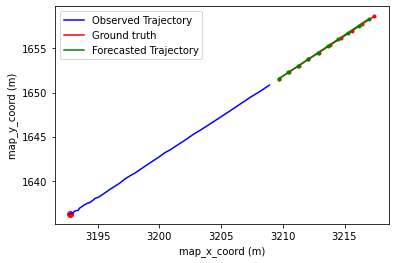

In [ ]:
for test_idx in range(64):
    TEST_INDEX = test_idx
    test_data_dic["GROUND_TRUTH"][0].shape
    origin_x_t, origin_y_t = test_data_dic["ORIGIN"][0][TEST_INDEX]
    x_absolute = test_data_dic["GROUND_TRUTH"][0][TEST_INDEX, : , 0]
    y_absolute = test_data_dic["GROUND_TRUTH"][0][TEST_INDEX, : , 1]
    x_forecasted = result[0][TEST_INDEX, : ,0]
    y_forecasted = result[0][TEST_INDEX, : ,1]
    y_absolute.shape
    y_forecasted.shape
    plt.plot(origin_x_t,origin_y_t,'-o',c='r') #starting point here
    plt.plot(x_absolute[:40],y_absolute[:40],'-',c='b', label = "Observed Trajectory") #input sequence
    plt.plot(x_absolute[40:],y_absolute[40:],'-',c='r', label = "Ground truth") #ground truth
    plt.plot(x_absolute[40:],y_absolute[40:],'.',c='r') #ground truth
    plt.plot(x_forecasted[:],y_forecasted[:],'-',c='g', label = "Forecasted Trajectory") #forecasted 
    plt.plot(x_forecasted[:],y_forecasted[:],'.',c='g') #forecasted 
    plt.xlabel('map_x_coord (m)')
    plt.ylabel('map_y_coord (m)')
    ax.set_aspect('equal')
    plt.legend()
    plt.show()